In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision



In [6]:
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Data

In [3]:
batch_size = 256
transform = transforms.Compose([transforms.ToTensor()])

train_set = CIFAR10(
    root = './../data_cifar10',
    train= True,
    download= True,
    transform=transform,
)
val_set = CIFAR10(
    root = './../data_cifar10',
    train= False,
    download= True,
    transform=transform,
)

train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(val_set, batch_size=batch_size,
                         shuffle=False,
                         num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


# Model

In [7]:
class CNNModel(nn.Module):
    def __init__(self, n_classes = 10):
        super(CNNModel, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride= 2)
        )

        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.conv_layer11 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.conv_layer12 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.dense1 = nn.Sequential(
            nn.Linear(512*2*2, 512),
            nn.ReLU()
        )
        self.dense2 = nn.Linear(512, n_classes)

        # self.initialize_weights()
    # def initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             init.xavier_uniform_(m.weight)
    #             if m.bias is not None:
    #                 init.zeros_(m.bias)
    #         elif isinstance(m, nn.Linear):
    #             init.xavier_uniform_(m.weight)
    #             if m.bias is not None:
    #                 init.zeros_(m.bias)
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = self.conv_layer11(x)
        x = self.conv_layer12(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)

        return x

In [8]:
model = CNNModel(10)

model.to(device)
# print(model)
print(device)

cuda


# Training

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [10]:
def evaluate(model, train_loader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100*running_correct / total
    test_loss = test_loss / len(test_loader)
    return test_loss, accuracy

In [13]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
epochs_max = 30

In [14]:
# train
for epoch in range(epochs_max):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(test_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward propagation
        loss.backward()
        #update weights
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100*running_correct/total
    epoch_loss = running_loss / (i+1)

    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Epoch [{epoch + 1}/{epochs_max}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/30], Loss: 0.1238, Accuracy: 95.82%, Test Loss: 0.2580, Test Accuracy: 91.88%
Epoch [2/30], Loss: 0.1661, Accuracy: 95.01%, Test Loss: 0.3057, Test Accuracy: 90.45%
Epoch [3/30], Loss: 0.1168, Accuracy: 96.07%, Test Loss: 0.1478, Test Accuracy: 95.04%
Epoch [4/30], Loss: 0.0654, Accuracy: 97.85%, Test Loss: 0.0959, Test Accuracy: 96.74%
Epoch [5/30], Loss: 0.0577, Accuracy: 97.92%, Test Loss: 0.0779, Test Accuracy: 97.44%
Epoch [6/30], Loss: 0.0555, Accuracy: 98.18%, Test Loss: 0.0976, Test Accuracy: 96.82%
Epoch [7/30], Loss: 0.0396, Accuracy: 98.71%, Test Loss: 0.0938, Test Accuracy: 97.08%
Epoch [8/30], Loss: 0.0431, Accuracy: 98.63%, Test Loss: 0.1730, Test Accuracy: 95.29%
Epoch [9/30], Loss: 0.0586, Accuracy: 97.93%, Test Loss: 0.1493, Test Accuracy: 95.20%
Epoch [10/30], Loss: 0.0444, Accuracy: 98.54%, Test Loss: 0.0629, Test Accuracy: 97.94%
Epoch [11/30], Loss: 0.0375, Accuracy: 98.74%, Test Loss: 0.0741, Test Accuracy: 97.84%
Epoch [12/30], Loss: 0.0369, Accuracy: 98

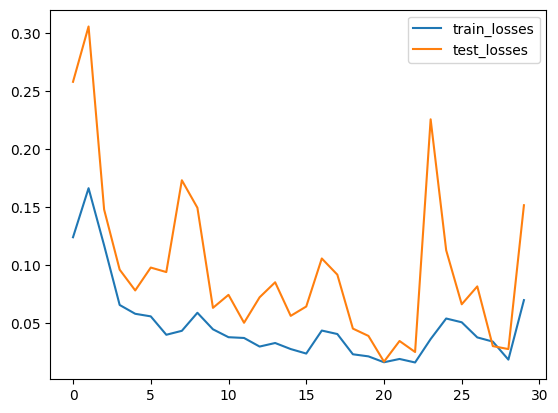

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

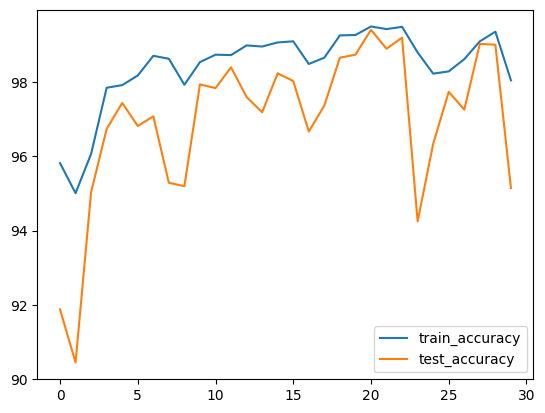

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()